# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Подключение и настройка необходимых библиотек

In [1]:
# отключение предупреждений
import warnings; warnings.filterwarnings('ignore', category=Warning)

In [2]:
# pip install -U scikit-learn

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from datetime import timedelta

pd.options.display.float_format = '{:.3f}'.format

In [4]:
# подключение библиотек машинного обучения

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_validate, cross_val_score
from functools import partial

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor as lgbr
from catboost import CatBoostRegressor as ctbr

## Подготовка данных

### Общая информация

In [5]:
try:
    data = pd.read_csv('datasets/autos.csv')
except FileNotFoundError:
    data = pd.read_csv('https://code.s3/datasets/autos.csv')

In [6]:
# взглянем на данные
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
# сразу удалим ненужные столбцы, которые содержат личную информацию и не влияют на стоимость машины 
data = data.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures', 'PostalCode'], axis=1)

In [8]:
# теперь взглянем на таблицу корреляции признаков
data.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
Price,1.000,0.027,0.159,-0.333,0.111
RegistrationYear,0.027,1.000,-0.001,-0.053,-0.012
Power,0.159,-0.001,1.000,0.024,0.043
Kilometer,-0.333,-0.053,0.024,1.000,0.010
RegistrationMonth,0.111,-0.012,0.043,0.010,1.000


In [9]:
# при проверке не были обнаружены мультиколлинеарные признаки, посмотрим на общую инфу
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        316879 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            334536 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              334664 non-null  object
 6   Kilometer          354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           321474 non-null  object
 9   Brand              354369 non-null  object
 10  NotRepaired        283215 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


In [10]:
# заметили пропущенные значения, посчитаем их количество
data.isna().sum()

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
dtype: int64

In [11]:
# взгянем на распределение признаков, чтобы выявить аномальные данные
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,354369.000,354369.000,354369.000,354369.000,354369.000
mean,4416.657,2004.234,110.094,128211.173,5.715
std,4514.159,90.228,189.850,37905.342,3.726
min,0.000,1000.000,0.000,5000.000,0.000
25%,1050.000,1999.000,69.000,125000.000,3.000
50%,2700.000,2003.000,105.000,150000.000,6.000
75%,6400.000,2008.000,143.000,150000.000,9.000
max,20000.000,9999.000,20000.000,150000.000,12.000


Заметны необычные данные:
- Нулевые значения в колонках `Price` `Power` -- похоже на выбросы
- `Kilometer` проверим на выбросы
- `RegistrationMonth` нулевые значения удалим
- `RegistrationYear` удалим несущесвующие года

Теперь подробнее поработаем с пропущенными значениями и выбросами, но сначала проверим данные на наличие дубликатов

In [12]:
data.duplicated().sum()

27543

In [13]:
# удалим их
data = data.drop_duplicates()

### Аномальные значения

In [14]:
#напишем функцию, благодаря которой мы сможем увидеть распределение признаков

def data_plot(data):
    """Строим сетку, где будут располагаться наши графики для каждого признака"""
    
    hist_box = plt.figure(figsize=(16, 8), constrained_layout=False)
    plt.title('Гистограммы распределений признаков', fontsize=20)
    plt.xticks([])
    plt.yticks([])

    grid = hist_box.add_gridspec(8, 14, wspace=1.7, hspace=0.1)
    
    # Boxplot и Hist для признака Price
    Price_b = hist_box.add_subplot(grid[0, :6])
    Price_h = hist_box.add_subplot(grid[1:3, :6])
    sns.boxplot(x='Price', data = data, ax=Price_b, color='pink')
    sns.distplot(data['Price'], ax=Price_h, color='pink')

    # Boxplot и Hist для признака Power 
    Power_b = hist_box.add_subplot(grid[0, 7:13])
    Power_h = hist_box.add_subplot(grid[1:3, 7:13])
    sns.boxplot(x='Power', data = data, ax=Power_b, color='green')
    sns.distplot(data['Power'], ax=Power_h, color='green')

    # Boxplot и Hist для признака Kilometer
    Kilometer_b = hist_box.add_subplot(grid[4, :6])
    Kilometer_h = hist_box.add_subplot(grid[5:7, :6])
    sns.boxplot(x='Kilometer', data = data, ax=Kilometer_b, color='blue')
    sns.distplot(data['Kilometer'], ax=Kilometer_h, color='blue')

    # Hist для Year и Month 
    year_h = hist_box.add_subplot(grid[4:5, 7:13])
    month_h = hist_box.add_subplot(grid[6:7, 7:13])
    sns.distplot(data['RegistrationYear'], ax=year_h, color='orange')
    sns.distplot(data['RegistrationMonth'], ax=month_h, color='orange');

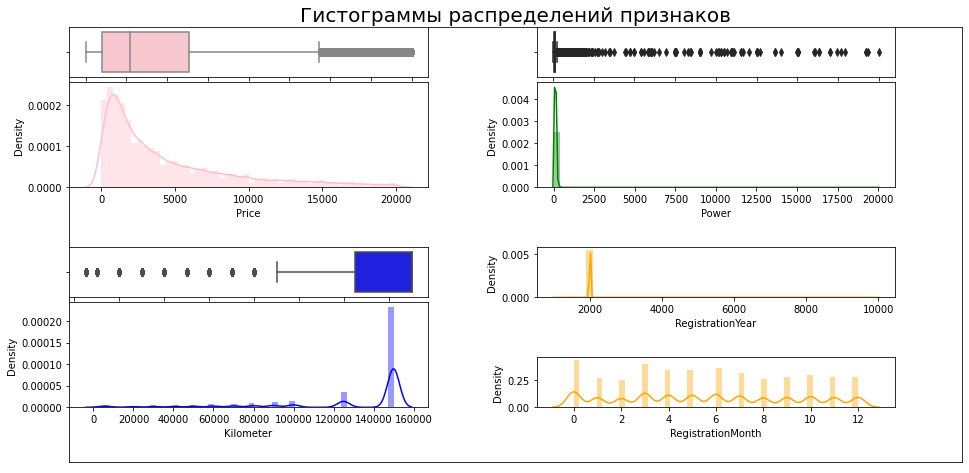

In [15]:
data_plot(data)

`Price`:
- Цены, выше 15000 -- выбросы. Нулевые значения, скорее всего, "отдам даром", но так как мы делаем сервис, который будет предсказывать рыночную стоимость авто, эти данные целесообразнее удалить 

`Power`:
- Машины, мощностью больше 5000 лошадиных сил -- это уже нереалистичные суперкары и больше походят на выбросы, чем реальные данные. Ограничим их, а нулевые значения заполним в зависимости от модели

`Kilometer`:
- Теоретически продаваться машины без пробега могут (вдруг скрутили), поэтому оставим их, плюс их не так много

`Year`:
- Года больше 2021 удалим, не станем заглядывать в будущее без надобности. Как и данные о машинах ранее 1980 года

`Month`:
- Удалим нулевые месяцы 

In [16]:
# учтем все требования
data = data.query(
    '(0 < Price < 15000) & (Power < 5000) & (1980<= RegistrationYear <= 2021) & (RegistrationMonth != 0)'
)

Итак, в нашем изначальном наборе данных было 354 369 данных, стало 269 994, то есть мы уменьшили размер нашей выборки примерно на четверть. Не станем удалять пропуски и заполним их в зависимости от пропущенных данных

In [17]:
# еще можно заметить интересную особенность, gasoline и petrol в английском языке -- это одно и то же, поэтому переименуем 
data['FuelType'].where(data['FuelType'] != 'gasoline', 'petrol', inplace=True)

In [18]:
# lpg и cng -- это все природный газ, можно объединить в other
data['FuelType'] = data['FuelType'].replace({'lpg': 'other', 'cng': 'other'})

### Пропущенные значения

In [19]:
# еще раз глянем, сколько пропущенных значений осталось
data.isna().sum()

Price                    0
VehicleType          20016
RegistrationYear         0
Gearbox               8141
Power                    0
Model                10915
Kilometer                0
RegistrationMonth        0
FuelType             16975
Brand                    0
NotRepaired          42756
dtype: int64

Пропуски заполним по такой логике:
- `Model` -- самым часто встречающимся в зависимости от бренда 
- `VehicleType`, `Gearbox` и `FuelType` зависят от модели авто, заполним также модой
- `NotRepaired` постараемся дополнить методом ближайших соседей (очень долго, лучше просто модой :)

In [20]:
# пропущенные значения заполним нулями
data[['Model','VehicleType','Gearbox','FuelType']] = data[['Model','VehicleType','Gearbox','FuelType']].fillna(0)

In [21]:
#выделим самую частую модель каждого бренда
brand_model = data.groupby('Brand').agg(lambda x: x.mode(dropna=False)[0])['Model']

In [22]:
# заполним пропуски
data.loc[data['Model']==0, 'Model'] = data.loc[
    data['Model']==0, 'Model'].apply(lambda x: brand_model[x])

У разных брендов машин модель может называться одинаковo. Поэтому сделаем дополнительных столбец "бренд+модель"

In [23]:
data['BrandModel'] = data['Brand'] + ' ' + data['Model']

In [24]:
# повторим для данных, которые зависят от модели
model_other = data.groupby('BrandModel').agg(lambda x: x.mode(dropna=False)[0])[['VehicleType','Gearbox','FuelType', 'Power']]

In [25]:
# заполним пропуски
for col in ['VehicleType','Gearbox','FuelType', 'Power']:
    data.loc[data[col]==0, col] = data.loc[data[col]==0, col].apply(lambda x: model_other[col].get(x))

Пропуски в колонке `NotRepaired` заполним модой, так как метод ближайших соседей уж очень долго работает. 

In [26]:
data['NotRepaired'] = data['NotRepaired'].fillna('no')

In [27]:
data = data.reset_index(drop=True)

In [28]:
#проверим результат
data.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
BrandModel           0
dtype: int64

In [29]:
# колонка с брендом и моделью автомобиля помогла нам при заполнении данных, теперь можем удалить ее
data.drop('BrandModel', axis=1, inplace=True)

### Кодировка данных

In [30]:
# итак, у нас есть количественные признаки, которые нужно привести к одному масштабу
# и категориальные переменные, которые нужно закодировать
numeric = ['Power', 'Kilometer', 'RegistrationYear']

categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [31]:
# посмотрим, сколько категорий в каждом столбце, чтобы определиться с техникой кодирования
[print(col, data[col].nunique()) for col in data[categorical]];

VehicleType 8
Gearbox 2
Model 248
FuelType 4
Brand 40
NotRepaired 2


Итак, к `VehicleType` `Gearbox` `FuelType` `NotRepaired` применим технику OHE, к колонкам `Model` и `Brand` применим Ordinal, чтобы не создавать очень много столбцов. 

In [32]:
def encoder_categorial(data):
    data = pd.get_dummies(data, columns =['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired'], drop_first=True)
    data[['Brand', 'Model']] = OrdinalEncoder().fit_transform(data[['Brand', 'Model']])
    return data

In [33]:
categ_col = ['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired', 'Brand', 'Model']
data_ohe = pd.get_dummies(data, columns =categ_col, drop_first=True)

In [34]:
data_encode = encoder_categorial(data)

In [35]:
#приведем все колонки к типу int
data_encode = data_encode.astype(int)
data_ohe = data_ohe.astype(int)

В кодировании категориальных признаков методом Ordinal есть один важный момент: модель будет считать, что в таких данных есть порядок, хотя это не так. Попробуем в дальнейшем создать датасет с большим количеством колонок, закодированный только методом OHE и проверим разницу. 

## Обучение моделей

In [36]:
# отделим целевой признак
X = data_encode.drop(['Price'], axis=1)
y = data_encode['Price']

X_ohe = data_ohe.drop(['Price'], axis=1)
y_ohe = data_ohe['Price']

In [37]:
# проверять модель будем на кросс-валидации, поэтому разделим выборку на тестовую и тренировочную
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.75, random_state=12
)

In [38]:
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(
    X_ohe, y_ohe, test_size=0.75, random_state=12
)

In [39]:
# проверим размерность выборок
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(67498, 18) (202496, 18)
(67498,) (202496,)


In [40]:
# приведем числовые признаки к одному масштабу
scaler = StandardScaler()
scaler_ohe = StandardScaler()

X_train[numeric] = scaler.fit_transform(X_train[numeric])
X_train_ohe[numeric] = scaler_ohe.fit_transform(X_train_ohe[numeric])

X_test[numeric] = scaler.transform(X_test[numeric])
X_test_ohe[numeric] = scaler_ohe.transform(X_test_ohe[numeric])

Метрикой качества будет RMSE. Для обучения используем модели LightGBM от майкрософт и CatBoost от яндекса. Помимо этого также проверим работу более простых моделей -- RandomForest и LinearRegressor

In [41]:
rmse = partial(mean_squared_error, squared=False)

In [42]:
# напишем функцию для определения результата кросс-валидации и времени обучения
def cv_results_train(model):
    cv = cross_validate(model, X_train, y_train, cv=3, scoring=make_scorer(rmse))
    result = np.mean(cv['test_score'])
    score_time = np.mean(cv['score_time'])
    return result, score_time

In [43]:
# и такую же для датасета, закодированным только методом ohe
def ohe_cv_results_train(model):
    cv = cross_validate(model, X_train_ohe, y_train_ohe, cv=3, scoring=make_scorer(rmse))
    result = np.mean(cv['test_score'])
    score_time = np.mean(cv['score_time'])
    return result, score_time

Перед тем, как приступить к обучению, создадим простейшую модель, которая всегда предсказывает средний результат. Так мы сможем сравнить результаты нашей будущей модели с результатами dummy модели, которая выдает только один вариант

In [44]:
dummy_reg = DummyRegressor(strategy='mean')

dummy_reg.fit(X_train, y_train)

DummyRegressor()

In [45]:
dummy_pred = dummy_reg.predict(X_test)

In [46]:
mean_squared_error(y_test, dummy_pred)**0.5

3658.0824091353197

#### Линейная регрессия

In [47]:
# посмотрим, как справится линейная регрессия
reg = LinearRegression().fit(X_train_ohe, y_train_ohe)

In [48]:
ohe_cv_results_train(reg)

(2317.6128004003344, 0.07613603274027507)

Линейная регрессия явно не лучшая в этом деле, хотя бы учится быстро. Интересно, что на данных, закодированных только OHE она справилась даже чуточку хуже

#### Случайный лес

In [49]:
rf = RandomForestRegressor(random_state=12).fit(X_train, y_train)

In [50]:
cv_results_train(rf)

(1555.6099825961962, 1.941781997680664)

Ого, случайный лес, результат значительно лучше, запомним и посмотрим, как справятся бустинги

In [51]:
# подберем гиперпараметры для него (обучается долго, поэтому я сразу введу найденные параметры )
rf_params = {'max_depth':         range(10, 110, 10),
             'n_estimators':      range(100, 500, 50),
             'min_samples_split': range(2, 5, 10)}

# rf_grid = RandomizedSearchCV(rf, rf_params, cv=3, n_jobs=-1)
# rf_grid.fit(X_train, y_train)

In [54]:
# запомним эту модель и позже проверим ее результат на тестовых данных
rf_grid_best = RandomForestRegressor(n_estimators=450, min_samples_split=2, max_depth=100, random_state=12).fit(X_train, y_train)

In [55]:
cv_results_train(rf_grid_best)

(1550.4017146021968, 9.268867333730062)

#### LightGBM

In [56]:
# LightGBM параметры
lgb_reg_params = {
    'learning_rate':    np.arange(0.05, 0.31, 0.05),
    'max_depth':        range(5, 16),
    'min_child_weight': range(1, 8),
    'n_estimators':     range(50, 150, 10),
    'num_leaves':       range(30, 100, 20)
}


In [57]:
lgb_model = lgbr()
lgb_model.fit(X=X_train, y=y_train, eval_metric='l2', verbose=False)

LGBMRegressor()

In [58]:
cv_results_train(lgb_model)

(1503.045445118242, 0.1185132662455241)

Результат значительно лучше, посмотрим, получится ли нам его улучшить после подбора параметров

In [59]:
categorical_feature = ['Model',
       'Brand', 'VehicleType_convertible', 'VehicleType_coupe',
       'VehicleType_other', 'VehicleType_sedan', 'VehicleType_small',
       'VehicleType_suv', 'VehicleType_wagon', 'Gearbox_manual',
       'FuelType_hybrid', 'FuelType_other', 'FuelType_petrol',
       'NotRepaired_yes']

In [60]:
%%time
lgb_grid = RandomizedSearchCV(lgb_model, lgb_reg_params, cv=3, n_jobs=-1)
lgb_grid.fit(X_train, y_train, categorical_feature=categorical_feature)

CPU times: user 4.78 s, sys: 777 ms, total: 5.55 s
Wall time: 21.7 s


RandomizedSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 ]),
                                        'max_depth': range(5, 16),
                                        'min_child_weight': range(1, 8),
                                        'n_estimators': range(50, 150, 10),
                                        'num_leaves': range(30, 100, 20)})

In [62]:
# посмотрим на лучший результат
lgb_grid.best_params_

{'num_leaves': 50,
 'n_estimators': 140,
 'min_child_weight': 2,
 'max_depth': 8,
 'learning_rate': 0.15000000000000002}

In [63]:
# запомним эту модель и проверим ее результат на нашей функции
lgb_grid_best = lgbr(num_leaves=90, n_estimators=110, min_child_weight=4, max_depth=11, learning_rate=0.15)

In [64]:
lgb_grid_best.fit(X_train, y_train, categorical_feature=categorical_feature)

LGBMRegressor(learning_rate=0.15, max_depth=11, min_child_weight=4,
              n_estimators=110, num_leaves=90)

In [65]:
cv_results_train(lgb_grid_best)

(1458.2445061218116, 0.1749256451924642)

Действительно, немного лучше, чем с параметрами по умолчанию. Да и училась она довольно быстро -- сплошные плюсы. Теперь проверим CatBoost

#### CatBoost

In [66]:
# CatBoost параметры
ctb_reg_params = {
    'learning_rate':     np.arange(0.03, 0.2, 0.05),
    'depth':             np.arange(6, 10),
    'l2_leaf_reg':       np.arange(0.5, 3, 0.5)
}

In [67]:
%%time
cat_model = ctbr(random_state=12,
                 eval_metric='RMSE',
                 iterations=1000,
                 verbose=False)

cat_model.fit(X=X_train, y=y_train, early_stopping_rounds=10)

CPU times: user 32.8 s, sys: 4.79 s, total: 37.6 s
Wall time: 15 s


In [68]:
cv_results_train(cat_model)

(1461.773170544325, 0.061468919118245445)

CatBoost справился значительно лучше. Попробуем подобрать параметры для него и улучшить метрику

In [69]:
cat_grid = RandomizedSearchCV(cat_model, ctb_reg_params, cv=3, n_jobs=-1)
cat_grid.fit(X_train, y_train, cat_features=categorical_feature)

RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostRegressor object at 0x1a342f5810>,
                   n_jobs=-1,
                   param_distributions={'depth': array([6, 7, 8, 9]),
                                        'l2_leaf_reg': array([0.5, 1. , 1.5, 2. , 2.5]),
                                        'learning_rate': array([0.03, 0.08, 0.13, 0.18])})

In [70]:
cat_grid.best_params_

{'learning_rate': 0.08, 'l2_leaf_reg': 1.0, 'depth': 9}

In [71]:
cat_grid_best = ctbr(
    random_state=12,
    eval_metric='RMSE',
    iterations=1000,
    verbose=False,
    learning_rate=0.08,
    l2_leaf_reg=1,
    depth=8
)

cat_grid_best.fit(X=X_train, y=y_train, early_stopping_rounds=10, cat_features=categorical_feature)

In [72]:
cv_results_train(cat_grid_best)

(1450.776785962528, 0.03197034200032552)

CatBoost победил в этой битве. Сравним результаты по времени обучения, результатам на тестовой выборках

## Анализ моделей

In [73]:
models = dict()

In [74]:
# напишем функцию для удобства финального анализа
def model_results(model, name: str):
    """Функция обучает модель и измеряет потраченное время. 
        Возвращает словарь:
        - название
        - время обучения
        - качество модели на кросс-валидации
        - качество на тестовой выборке
    """
    global X_train, y_train, X_test, y_test
    
    # Измерим скорость обучения
    start = timer()
    model.fit(X_train, y_train)
    end = timer()
    fit_time = str(timedelta(seconds=end - start))
    
    
    # Измерим скорость предсказаний
    start = timer()
    test_pred =  model.predict(X_test)
    end = timer()
    predict_time = str(timedelta(seconds=end - start))
    score_test = rmse(y_test, test_pred)
        
    # Добавим показатели в словарь
    models[name] = {'name': name,
                    'fit_time': fit_time,
                    'score_cv': cv_results_train(model)[0],
                    'score_time': cv_results_train(model)[1],
                    'score_test': score_test,
                    'predict_time': predict_time}

**У нас есть 5 моделей для сравнения:**
- Случайный лес (rf)
- LightGBM: параметры по умолчанию (lgb_model)
- LightGBM: после подбора параметров (lgb_grid_best)
- CatBoost: параметры по умолчанию (cat_model)
- CatBoost: после подбора параметров (cat_grid_best)

In [75]:
finish_model = {'Случайный лес': rf,
                'LightGBM: по умолчанию': lgb_model,
                'LightGBM: после подбора': lgb_grid_best,
                'CatBoost: по умолчанию': cat_model,
                'CatBoost: после подбора': cat_grid_best
               }

In [76]:
for model in finish_model.items():
    model_results(model[1], model[0])

In [77]:
score_table = pd.DataFrame.from_dict(data=models, orient='index').sort_values('score_test', ascending=False)

In [78]:
score_table

,name,fit_time,score_cv,score_time,score_test,predict_time
Случайный лес,Случайный лес,0:00:34.687207,1555.610,1.605,1531.125,0:00:11.104922
LightGBM: по умолчанию,LightGBM: по умолчанию,0:00:00.860618,1503.045,0.128,1509.337,0:00:01.187194
CatBoost: по умолчанию,CatBoost: по умолчанию,0:00:14.896057,1461.773,0.023,1454.269,0:00:00.199638
LightGBM: после подбора,LightGBM: после подбора,0:00:00.951553,1458.245,0.243,1446.221,0:00:01.910787
CatBoost: после подбора,CatBoost: после подбора,0:00:16.838459,1450.777,0.037,1434.981,0:00:00.363306


### Проверим модели на выборке, закодированной только методом OHE

Не станем распыляться на какие попало модели, сразу проверим две: LightGBM и CatBoost. Для каждого сразу подберем параметры 

In [79]:
lgbm_ohe = lgbr()

In [80]:
# чтоб не тянуть время ниже -- наилучший результат
# lgbm_ohe_grid.fit(X_train_ohe, y_train_ohe)
#lgbm_ohe_grid.best_params_

#думала сначала тут сделать categorical_feature, но их уж очень много получилось

In [ ]:
lgbm_ohe_best = lgbr(num_leaves=70, n_estimators=120, min_child_weight=1, max_depth=13, learning_rate=0.15).fit(X_train_ohe, y_train_ohe)

In [ ]:
cat_ohe = ctbr(random_state=12, eval_metric='RMSE', iterations=1000, verbose=False)

In [ ]:
# долго ищет, поэтому ниже модель с лучшими параметрами
# cat_ohe_grid = RandomizedSearchCV(cat_ohe, ctb_reg_params, cv=3, n_jobs=-1)
# cat_ohe_grid.fit(X_train_ohe, y_train_ohe)
#cat_ohe_grid.best_params_

In [ ]:
cat_ohe_best = ctbr(random_state=12, eval_metric='RMSE', iterations=1000, verbose=False, learning_rate=0.13, l2_leaf_reg=2, depth=9).fit(X_train_ohe, y_train_ohe)

In [ ]:
cat_pred = cat_ohe_best.predict(X_test_ohe)

In [ ]:
score_test = rmse(y_test_ohe, cat_pred)
score_test

In [ ]:
jgb_pred = lgbm_ohe_best.predict(X_test_ohe)

In [ ]:
lgb_test = rmse(y_test_ohe, jgb_pred)
lgb_test

**Вывод:**
    Лучше всего справился CatBoost на выборке, закодированной только техникой OHE и с подобранными гиперпараметрами. Результат: 1419